<a href="https://colab.research.google.com/github/Faizanealiqazi/TSP_CUCKOO_SEARCH/blob/main/NIIA_PROJECT_EFFECTS_OF_POPULATION_ON_CUCKOO_SEARCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.cm import get_cmap

In [ ]:
"""
Possible Lévy distribution
Mantegna's Algorithm // Currently applied
Inverse Transform Sampling
Chambers-Mallows-Stuck Method (CMS)
Series Expansion
Monte Carlo Simulation
Fourier Transform Sampling
Rejection Sampling
"""

In [3]:
"""
Initialize population with random tours
Evaluate the fitness of each tour

for each generation do
    Generate a new tour by Lévy flight from an existing tour
    Evaluate its fitness
    Choose a random nest (tour) from the population
    if the fitness of the new tour is better than the chosen nest then
        Replace the chosen nest with the new tour
    end if
    Abandon a fraction pa of the worst nests and generate new ones
    Keep the best tour found so far
end for

Return the best tour
"""

In [4]:
# Function to plot the initial configuration of the TSP
def plot_initial_tsp_graph(cities):
    plt.figure(figsize=(10, 6))
    plt.scatter(cities[:, 0], cities[:, 1], color='red')
    plt.title('Initial Traveling Salesman Problem Graph')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(True)
    plt.show()

# Function to generate a random path
def random_path(num_cities):
    return np.random.permutation(num_cities)

def random_path_with_fixed_start(num_cities, start_city=0):
    path = np.random.permutation(num_cities)
    start_index = np.where(path == start_city)[0][0]
    path[0], path[start_index] = path[start_index], path[0]
    return path

# Function to calculate total distance of a path
def total_distance(cities, path):
    return sum(np.linalg.norm(cities[path[i]] - cities[path[(i + 1) % len(path)]]) for i in range(len(path)))

# Levy flight function (Mantegna's Algorithm) for TSP
def levy_flight(beta, size=1):
    # Calculation of sigma (standard deviation)
    sigma_u = (math.gamma(1 + beta) * math.sin(math.pi * beta / 2) /
               (math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
    sigma_v = 1

    u = np.random.normal(0, sigma_u, size)
    v = np.random.normal(0, sigma_v, size)
    step = u / np.fabs(v) ** (1 / beta)

    return step

# Cuckoo Search for TSP with simple Lévy flights
def cuckoo_search_tsp(cities, nests, fitness, n, max_iter, pa, beta=1.5):
    num_cities = len(cities)

    # Subsample nests for the current population size
    current_nests = nests[:n]
    current_fitness = fitness[:n]

    # Find the best solution in the initial population
    best_nest_idx = current_fitness.argmin()
    best_nest = current_nests[best_nest_idx]
    best_fitness = current_fitness[best_nest_idx]

    for iter in range(max_iter):
        for i in range(n):
            new_nest = np.copy(nests[i])

            # Get a step size from Lévy flight
            step_size = levy_flight(beta)
            # Apply the step to a randomly chosen subset of the tour
            city_indices = np.sort(np.random.choice(num_cities, 2, replace=False))
            start, end = city_indices
            if (start + step_size) % num_cities < end:
                new_nest[start:end] = np.roll(new_nest[start:end], int(step_size))
            else:
                new_nest[end:(start + int(step_size)) % num_cities] = np.roll(new_nest[end:(start + int(step_size)) % num_cities], int(step_size))

            # Calculate the fitness of the new solution
            fnew = total_distance(cities, new_nest)

            # Greedily select the better solution
            if fnew < fitness[i]:
                nests[i] = new_nest
                fitness[i] = fnew

                # Update the best solution found so far
                if fnew < best_fitness:
                    best_nest = new_nest
                    best_fitness = fnew

        # Abandon a fraction (pa) of the worst nests
        for i in range(n):
            if np.random.rand() < pa:
                nests[i] = random_path(num_cities)  # Generate a new random solution for a nest
                fitness[i] = total_distance(cities, nests[i])  # Recalculate its fitness

    return best_nest, best_fitness


# Function to run the Cuckoo Search algorithm for different population sizes
def run_cuckoo_search(cities, population_sizes, max_iter, pa, max_nests=100):
    num_cities = len(cities)

    # Generate a large set of initial nests and fitnesses
    all_nests = [random_path(num_cities) for _ in range(max_nests)] # Initialize nests with random tours
    all_fitness = np.array([total_distance(cities, nest) for nest in all_nests])  # Fitness of each nest

    best_distances = []
    best_paths = []

    for n in population_sizes:
        best_path, best_fitness = cuckoo_search_tsp(cities, all_nests, all_fitness, n, max_iter, pa)
        best_distances.append(best_fitness)
        best_paths.append(best_path)
        print(f"Population size: {n}, Best Distance: {best_fitness}")

    return best_distances, best_paths

# Function to find the best population size
def test_population_sizes(cities, population_sizes, max_iter, pa, best_distances):
    best_index = np.argmin(best_distances)
    best_population_size = population_sizes[best_index]
    best_distance = best_distances[best_index]
    return best_population_size, best_distance

# Function to plot the effect of population size on the Cuckoo Search performance
def test_population_sizes_plot(population_sizes, best_distances):
    plt.figure(figsize=(10, 6))
    plt.plot(population_sizes, best_distances, marker='o')
    plt.title('Effect of Population Size on Cuckoo Search for TSP')
    plt.xlabel('Population Size')
    plt.ylabel('Best Distance Found')
    plt.grid(True)
    plt.show()


def plot_best_paths(cities, best_paths, best_index=None, plot_best_flag_only=True):
    num_paths = len(best_paths)
    #Generating a color map
    cmap = get_cmap('viridis', num_paths)

    # Filtering to only plot the best path if flag is set
    paths_to_plot = [best_paths[best_index]] if plot_best_flag_only and best_index is not None else best_paths

    for i, best_path in enumerate(paths_to_plot):
        plt.figure(figsize=(12, 8))
        plt.scatter(cities[:, 0], cities[:, 1], color='red', zorder=5)
        color = cmap(i)
        for j in range(len(best_path)):
            start_city = cities[best_path[j]]
            end_city = cities[best_path[(j + 1) % len(best_path)]]
            plt.plot([start_city[0], end_city[0]], [start_city[1], end_city[1]], color=color, zorder=1)
            # Annotating the city with the order number if not plotting the best path only
            plt.annotate(f'{j}', (start_city[0], start_city[1]), textcoords="offset points", xytext=(0,10), ha='center', zorder=10)

        plt.title('Best Path Found by Cuckoo Search' if plot_best_flag_only else 'Best Paths Found by Cuckoo Search for Different Population Sizes')
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.grid(True)
        plt.show()


In [5]:
num_cities = 100
max_iter = 1000
pa = 0.25
population_sizes = [20, 40, 80, 100]  # Different population sizes to test
cities = np.random.rand(num_cities, 2)

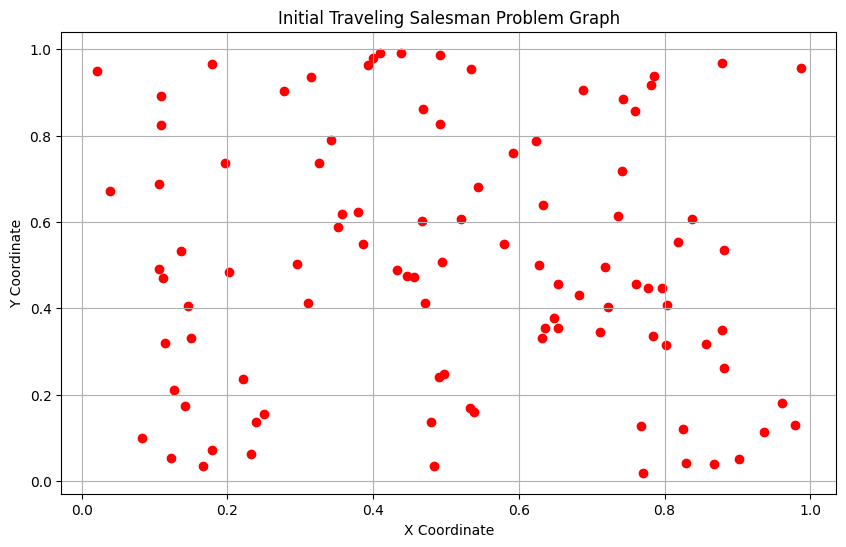

Population size: 20, Best Distance: 44.02015876093822
Population size: 40, Best Distance: 42.72102813319591
Population size: 80, Best Distance: 42.22282456596127
Population size: 100, Best Distance: 40.86031850414327
The best population size is 100 with a distance of 40.86031850414327.


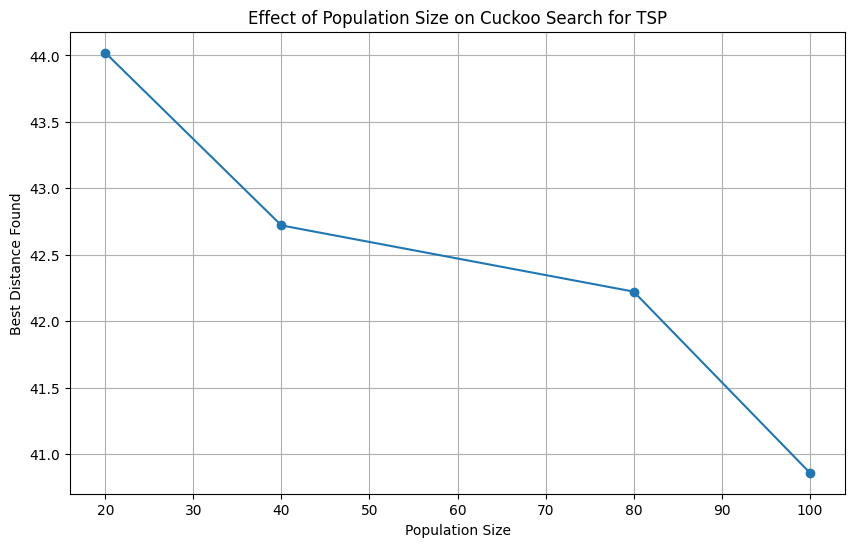

<ipython-input-4-2eda0c321148>:121: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('viridis', num_paths)


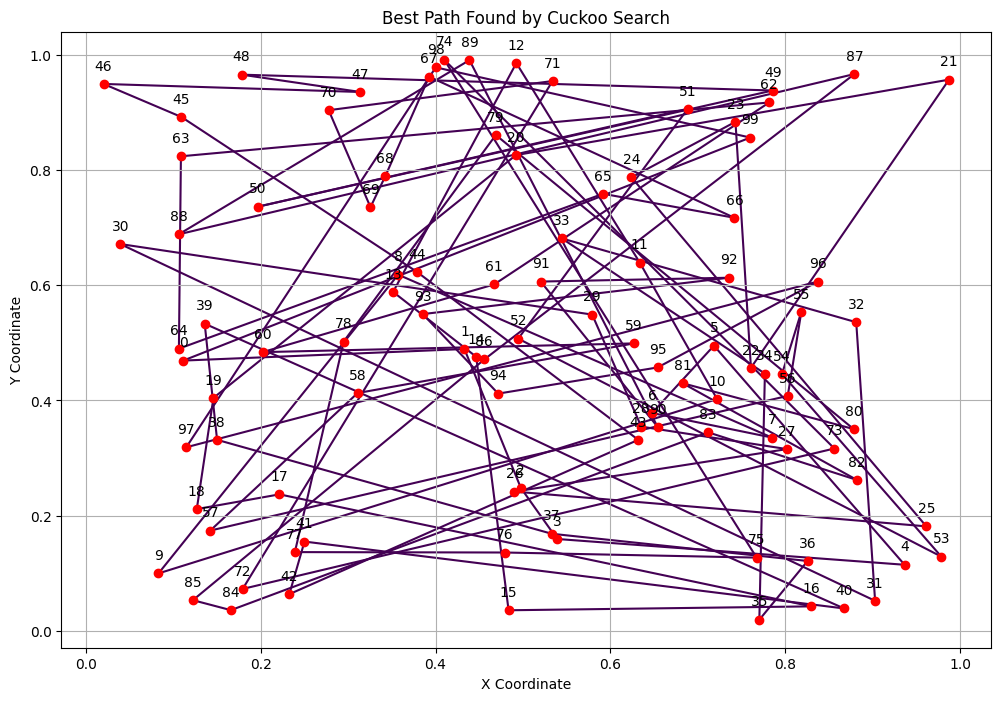

In [6]:
# Plot the initial TSP graph
plot_initial_tsp_graph(cities)

# Run the Cuckoo Search algorithm for different population sizes
best_distances, best_paths = run_cuckoo_search(cities, population_sizes, max_iter, pa)

# Find the best population size based on the best distances obtained
best_population_size, best_distance = test_population_sizes(cities, population_sizes, max_iter, pa, best_distances)
print(f"The best population size is {best_population_size} with a distance of {best_distance}.")

# Plot the effect of population size on the Cuckoo Search performance
test_population_sizes_plot(population_sizes, best_distances)

# Retrieve the best path for the best population size
best_index = population_sizes.index(best_population_size)
best_path = best_paths[best_index]

print("")

# Plot best paths for each population size
plot_best_paths(cities, best_paths, best_index)

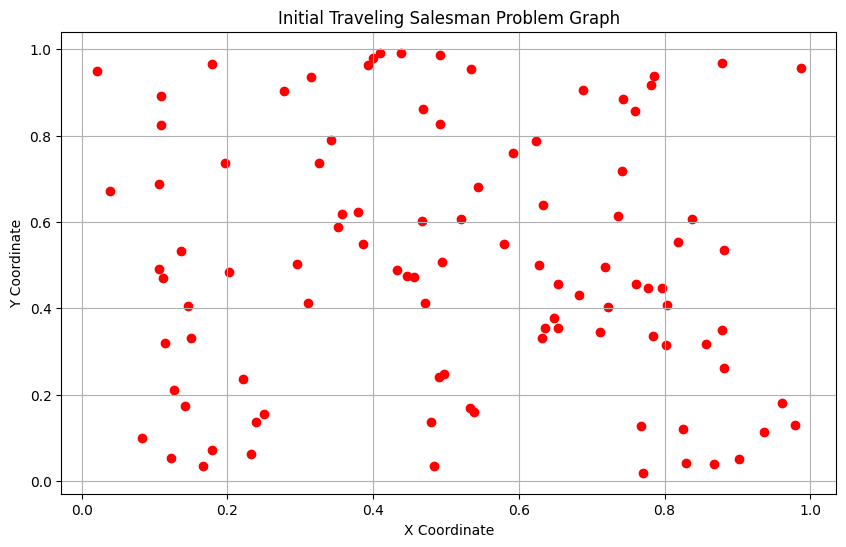

Population size: 20, Best Distance: 44.49382262813638
Population size: 40, Best Distance: 42.81591209278419
Population size: 80, Best Distance: 42.42419247907532
Population size: 100, Best Distance: 42.86926500318308
The best population size is 80 with a distance of 42.42419247907532.


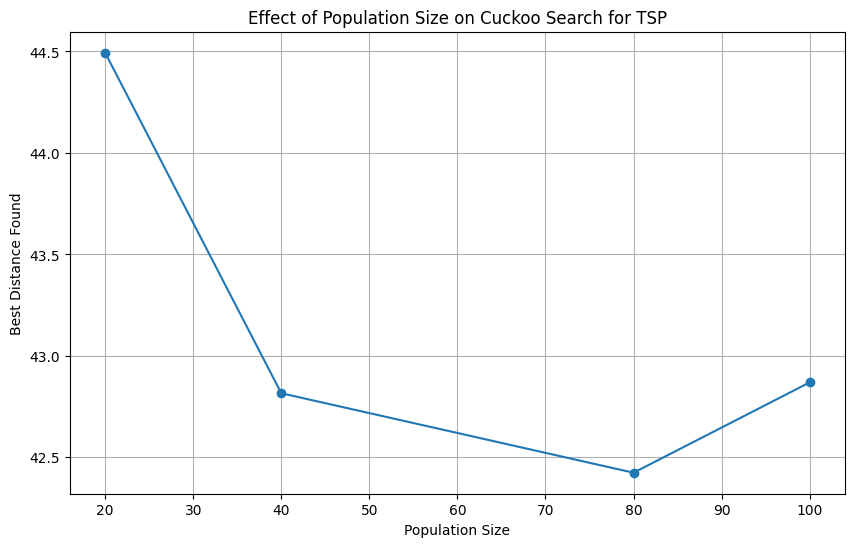

<ipython-input-4-2eda0c321148>:121: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('viridis', num_paths)


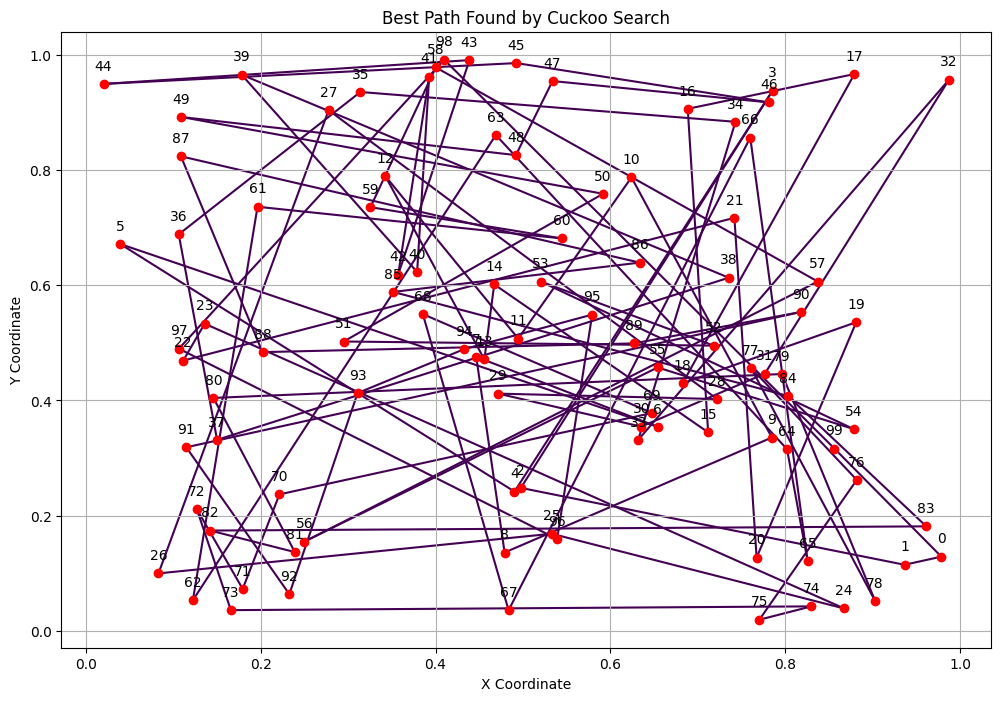

In [7]:
# Plot the initial TSP graph
plot_initial_tsp_graph(cities)

# Run the Cuckoo Search algorithm for different population sizes
best_distances, best_paths = run_cuckoo_search(cities, population_sizes, max_iter, pa)

# Find the best population size based on the best distances obtained
best_population_size, best_distance = test_population_sizes(cities, population_sizes, max_iter, pa, best_distances)
print(f"The best population size is {best_population_size} with a distance of {best_distance}.")

# Plot the effect of population size on the Cuckoo Search performance
test_population_sizes_plot(population_sizes, best_distances)

# Retrieve the best path for the best population size
best_index = population_sizes.index(best_population_size)
best_path = best_paths[best_index]

print("")

# Plot best paths for each population size
plot_best_paths(cities, best_paths, best_index)

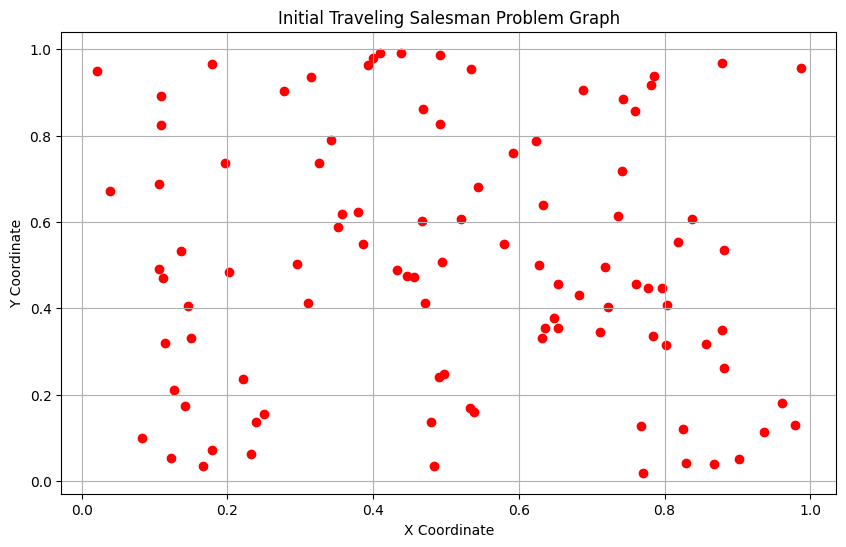

Population size: 20, Best Distance: 43.35231202519805
Population size: 40, Best Distance: 42.96291183144546
Population size: 80, Best Distance: 42.35036365972656
Population size: 100, Best Distance: 42.35721865950132
The best population size is 80 with a distance of 42.35036365972656.


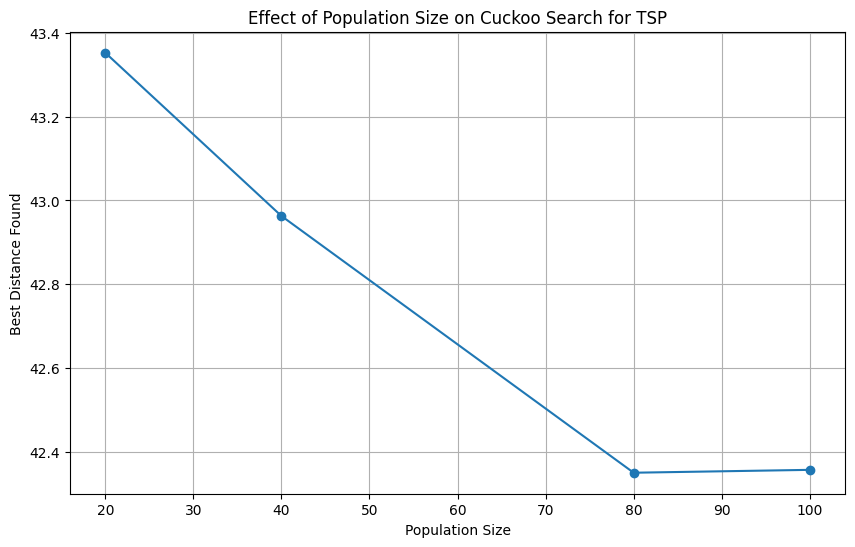

<ipython-input-4-2eda0c321148>:121: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('viridis', num_paths)


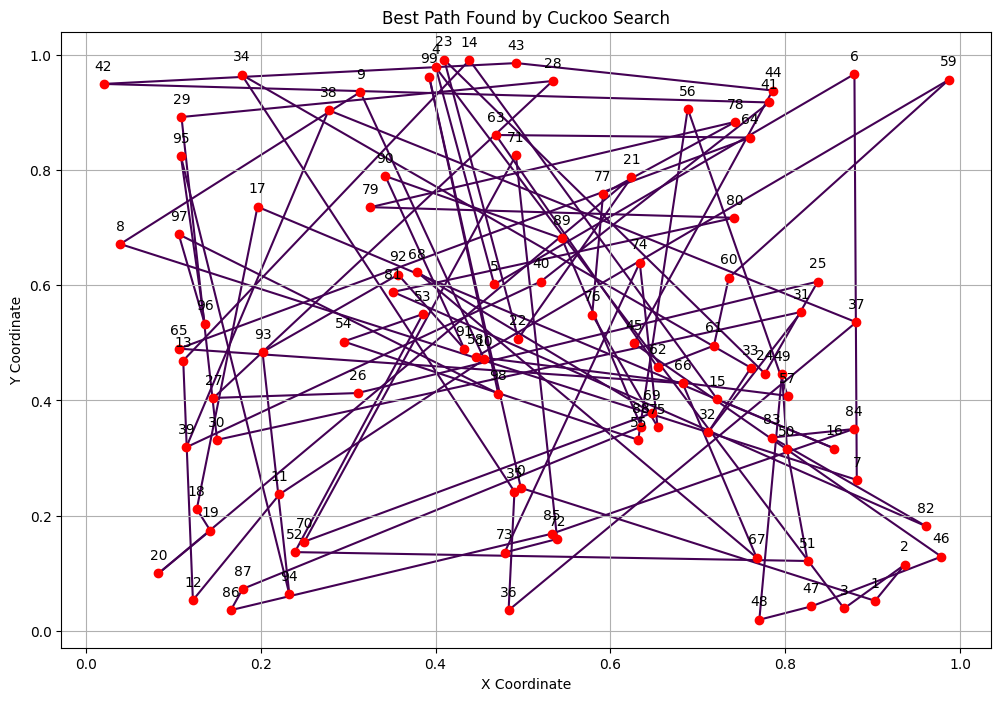

In [8]:
# Plot the initial TSP graph
plot_initial_tsp_graph(cities)

# Run the Cuckoo Search algorithm for different population sizes
best_distances, best_paths = run_cuckoo_search(cities, population_sizes, max_iter, pa)

# Find the best population size based on the best distances obtained
best_population_size, best_distance = test_population_sizes(cities, population_sizes, max_iter, pa, best_distances)
print(f"The best population size is {best_population_size} with a distance of {best_distance}.")

# Plot the effect of population size on the Cuckoo Search performance
test_population_sizes_plot(population_sizes, best_distances)

# Retrieve the best path for the best population size
best_index = population_sizes.index(best_population_size)
best_path = best_paths[best_index]

print("")

# Plot best paths for each population size
plot_best_paths(cities, best_paths, best_index)